In [1]:
from werkzeug.utils import secure_filename
import os
import re
from PIL import Image, ImageDraw, ImageFont
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
import matplotlib.pyplot as plt
import matplotlib.patches as patches

model_id = "google/paligemma-3b-mix-224"
processor = AutoProcessor.from_pretrained(model_id, use_fast=True)
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
).to("cuda" if torch.cuda.is_available() else "cpu").eval()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
def process_bbox(image_path, bbox_string, output_path):
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # You can set a font if you have one, else use default
    try:
        font = ImageFont.truetype("arial.ttf", size=16)
    except:
        font = ImageFont.load_default()

    pattern = r"<loc(\d{4})><loc(\d{4})><loc(\d{4})><loc(\d{4})>\s*([a-zA-Z]+)"
    matches = re.findall(pattern, bbox_string)

    for ymin_str, xmin_str, ymax_str, xmax_str, label in matches:
        ymin = int(ymin_str) / 1000 * height
        xmin = int(xmin_str) / 1000 * width
        ymax = int(ymax_str) / 1000 * height
        xmax = int(xmax_str) / 1000 * width

        # Draw rectangle
        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline='red', width=2)

        # Draw label
        text_position = (xmin, ymin - 15 if ymin > 15 else ymin + 5)
        draw.text(text_position, label, fill='yellow', font=font)

    image.save(output_path)

In [3]:

def process_image(input_path, output_path):
    image = Image.open(input_path).convert("RGB")
    # Add <image> token prefix per model requirement
    prompt = "<image> detect chair ; table ; bed ; sofa ; shelf\n"

    inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)
    input_len = inputs["input_ids"].shape[-1]

    with torch.inference_mode():
        outputs = model.generate(**inputs, max_new_tokens=200, do_sample=False)
        outputs = outputs[0][input_len:]

    result = processor.decode(outputs, skip_special_tokens=True)
    print(f"Model detection output: {result}")

    process_bbox(input_path, result, output_path)


In [7]:

process_image(input_path='static/uploads/room.jpg',output_path='static/processed/processed_room.jpg')

Model detection output: <loc0596><loc0000><loc0911><loc0233> shelf ; <loc0596><loc0350><loc0905><loc0920> sofa ; <loc0720><loc0181><loc0913><loc0350> chair ; <loc0745><loc0397><loc0871><loc0612> table


In [ ]:
from datasets import load_dataset

ds = load_dataset("byliu/DeepFurniture")

In [57]:
image= ds[0]['jpg']

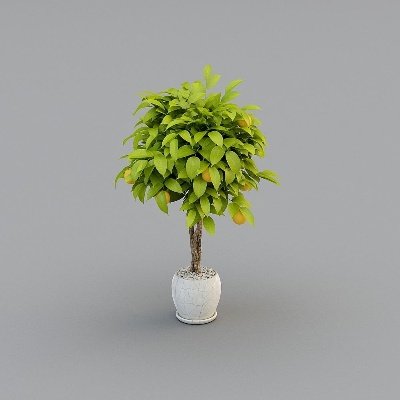

In [58]:
image

In [60]:
ds

Dataset({
    features: ['jpg', '__key__', '__url__'],
    num_rows: 104368
})

In [ ]:
import os
from datasets import load_dataset
from PIL import Image
from ultralytics import YOLO
import torch

# ----------- CONFIGURABLES -----------

CLASS_LABELS = {0: 'Cupboard', 1: 'Sofa', 2: 'chair', 3: 'fridge', 4: 'table', 5: 'tv'}
TARGET_CLASSES = set(CLASS_LABELS.values())

OUTPUT_DIR = "classified_images"
MODEL_PATH = r"D:\Code\Python\Kaggle\appian\round 2\Appian-hackathon-R2\flask\runs\classify\train3\weights\best.pt"
DATASET_NAME = "byliu/DeepFurniture"
SPLIT = "train"
START_INDEX = 0
END_INDEX = 1000
CONF_THRESHOLD = 0.6  # <-- Set your confidence threshold here

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------- LOAD MODEL -----------
model = YOLO(MODEL_PATH)
model.fuse()
model.to(DEVICE)

# ----------- LOAD DATASET -----------
ds = load_dataset(DATASET_NAME, split=SPLIT)

# ----------- CREATE OUTPUT FOLDERS -----------
for cls in TARGET_CLASSES:
    os.makedirs(os.path.join(OUTPUT_DIR, cls), exist_ok=True)

# ----------- CLASSIFY IMAGES -----------
for idx in range(START_INDEX, END_INDEX):
    try:
        image = ds[idx]['jpg']
        if isinstance(image, torch.Tensor):
            image = Image.fromarray(image.numpy())

        results = model.predict(image, device=DEVICE)[0]
        cls_id = int(results.probs.top1)
        confidence = float(results.probs.top1conf)
        cls_name = CLASS_LABELS.get(cls_id, "unknown")

        # Only save if class is in target and confidence is high enough
        if cls_name in TARGET_CLASSES and confidence >= CONF_THRESHOLD:
            save_path = os.path.join(OUTPUT_DIR, cls_name, f"{idx}.jpg")
            image.save(save_path)
            print(f"[{idx}] → {cls_name} ({confidence:.2f})")

    except Exception as e:
        print(f"Error at index {idx}: {e}")


In [9]:


# ✅ Imports
from transformers import AutoProcessor, AutoModelForImageTextToText
from PIL import Image
import torch

# ✅ Load the model and processor
model_id = "google/paligemma-3b-mix-224"
processor = AutoProcessor.from_pretrained(model_id, use_fast=True)
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
).to("cuda" if torch.cuda.is_available() else "cpu").eval()



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [69]:
len(('sorry, as a base vlm i am not trained to answer this question').split())

13

In [72]:

# ✅ Structured detection prompt using correct syntax
# prompt = "<image> detect 'Cupboard'; 'Sofa'; 'chair'; 'fridge'; 'table' ; 'tv' \n"
OUTPUT_DIR = "classified_images_gemma"
os.makedirs(OUTPUT_DIR,exist_ok=True)
min_val = 32000
max_val = len(ds)
for i in range(min_val,max_val):
    prompt = "<image> caption in one word using a furniture type"
    image = ds[i]['jpg']
    if image is None:
        continue
    # ✅ Prepare input (image first, then prompt)
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)
    input_len = inputs["input_ids"].shape[-1]

    # ✅ Generate detection output
    with torch.inference_mode():
        outputs = model.generate(**inputs, max_new_tokens=200, do_sample=False)
        outputs = outputs[0][input_len:]

    # ✅ Decode and print the result
    result = processor.decode(outputs, skip_special_tokens=True)
    result = result.lower()
    if len((str(result)).split())>3:
        continue
    if os.path.exists(os.path.join(OUTPUT_DIR,result)):
        image.save(os.path.join(OUTPUT_DIR,result,f'{i}.jpg'))
    else:
        os.makedirs(os.path.join(OUTPUT_DIR,result),exist_ok=True)
        image.save(os.path.join(OUTPUT_DIR,result,f'{i}.jpg'))


    # print(result)
    


In [15]:
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_bboxes(image, bbox_string):
    width, height = image.size

    # Pattern matches four <locNNNN> groups followed by a label string
    pattern = r"<loc(\d{4})><loc(\d{4})><loc(\d{4})><loc(\d{4})>\s*([a-zA-Z]+)"
    matches = re.findall(pattern, bbox_string)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for idx, (ymin_str, xmin_str, ymax_str, xmax_str, label) in enumerate(matches):
        ymin = int(ymin_str) / 1000 * height
        xmin = int(xmin_str) / 1000 * width
        ymax = int(ymax_str) / 1000 * height
        xmax = int(xmax_str) / 1000 * width

        box_width = xmax - xmin
        box_height = ymax - ymin

        rect = patches.Rectangle(
            (xmin, ymin), box_width, box_height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        ax.text(xmin, ymin - 10, label, fontsize=12, color='yellow',
                bbox=dict(facecolor='red', alpha=0.5, pad=2))

    plt.axis('off')
    plt.show()


In [8]:
import os
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel
import numpy as np
device='cuda' if torch.cuda.is_available() else 'cpu'
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# def generate_clip_embeddings_npz(image_folder):
#     embeddings = []
#     image_names = []

#     for filename in sorted(os.listdir(image_folder)):
#         if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
#             image_path = os.path.join(image_folder, filename)
#             image = Image.open(image_path).convert("RGB")

#             inputs = processor(images=image, return_tensors="pt").to(device)
#             with torch.no_grad():
#                 outputs = model.get_image_features(**inputs)

#             emb = outputs.cpu().numpy()
#             emb /= np.linalg.norm(emb, axis=1, keepdims=True)

#             embeddings.append(emb[0])
#             image_names.append(filename)

#     embeddings = np.vstack(embeddings)
#     image_names = np.array(image_names)

#     save_path = os.path.join(r'D:\Code\Python\Kaggle\appian\round 2\Appian-hackathon-R2\flask\dataset\NPZ', f"{os.path.basename(os.path.normpath(image_folder))}.npz")
#     np.savez(save_path, embeddings=embeddings, image_names=image_names)

#     print(f"Saved embeddings and image names to {save_path}")
# dataset_dir = r'D:\Code\Python\Kaggle\appian\round 2\Appian-hackathon-R2\flask\dataset\images\classified_images_gemma'
# folders = os.listdir(dataset_dir)
# print(folders)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
for folder in folders:
    folder_path = f"{dataset_dir}/{folder}"
    generate_clip_embeddings_npz(folder_path)


In [9]:
import os
import torch
import numpy as np
from transformers import CLIPProcessor, CLIPModel

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
# clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32",use_fast=True)

def embed_and_save_furniture_types(types_list, save_path):
    """
    Embed furniture type names and save embeddings and types to an npz file.

    Args:
        types_list (list of str): List of furniture type names.
        save_path (str): Path to save the npz file.
    """
    inputs = processor(text=types_list, return_tensors="pt", padding=True).to('cuda')
    with torch.no_grad():
        embeddings = model.get_text_features(**inputs)
    embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)
    embeddings_np = embeddings.cpu().numpy()
    types_array = np.array(types_list)

    # Save embeddings and types as npz
    np.savez(save_path, embeddings=embeddings_np, types=types_array)
    print(f"Saved embeddings and types to {save_path}")
embed_and_save_furniture_types(folders,r'D:\Code\Python\Kaggle\appian\round 2\Appian-hackathon-R2\flask\dataset\types.npz')

Saved embeddings and types to D:\Code\Python\Kaggle\appian\round 2\Appian-hackathon-R2\flask\dataset\types.npz
